# Tracklet Association

This is a notebook example to demonstrate the application of PostgresSQL cytotoxicity database to enhance query performance with parallel processing. Then a tracklet association of relinking small tracklets are performed with the DB engine to produce long tracked results.

We will cover 3 steps:
1. Loading CSV files to PostgresSQL
2. Demonstration of data query
3. Visualization of track kymographs
4. Compute tracklet association.

In [39]:
import os
import pandas as pd
import dask.dataframe as dd
import psycopg2
from sqlalchemy import create_engine
from concurrent.futures import ThreadPoolExecutor
from urllib.parse import quote_plus
from multiprocessing import cpu_count
from psycopg2 import sql
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

## Data Loading

In [2]:
METADATA = {
    "condition": ["WT","WT","Cyto","Cyto","CancerOnly","TCellOnly"],
    "cell_type": ["cancer","tcell","cancer","tcell","cancer","tcell"],
    "path": [
        "/mnt/Data/UTSE/2023_11_18_1G4PrimCD8_WT_HCT116_CTFR_100nM_CTG_500nM_ICAM5ug_framerate10sec_flow_0p15mlperh_analysis/plots/combined/roi5/data_WT_cancer",
        "/mnt/Data/UTSE/2023_11_18_1G4PrimCD8_WT_HCT116_CTFR_100nM_CTG_500nM_ICAM5ug_framerate10sec_flow_0p15mlperh_analysis/plots/combined/roi5/data_WT_tcell",
        "/mnt/Data/UTSE/2023_11_24_1G4PrimCD8_Nyeso1_HCT116_CTFR_100nM_ICAM5ug_framerate10sec_flow_0p1mlperh_analysis/plots/combined/roi5/data_Cyto_cancer",
        "/mnt/Data/UTSE/2023_11_24_1G4PrimCD8_Nyeso1_HCT116_CTFR_100nM_ICAM5ug_framerate10sec_flow_0p1mlperh_analysis/plots/combined/roi5/data_Cyto_tcell",
        "/mnt/Data/UTSE/2023_10_03_Nyeso1_HCT116_framerate_10sec_flowrate_0p15mlperh_analysis/plots/combined/roi5/data_Cancer_cancer",
        "/mnt/Data/UTSE/2023_12_07_1G4PrimCD8_CTFR100nM_ICAM5ug_framerate10sec_flow0p1mlperh_withIL2_analysis/plots/combined/roi5/data_TCell_tcell",
    ]
}

metadata_df = pd.DataFrame.from_dict(METADATA)
metadata_df

,condition,cell_type,path
0,WT,cancer,/mnt/Data/UTSE/2023_11_18_1G4PrimCD8_WT_HCT116...
1,WT,tcell,/mnt/Data/UTSE/2023_11_18_1G4PrimCD8_WT_HCT116...
2,Cyto,cancer,/mnt/Data/UTSE/2023_11_24_1G4PrimCD8_Nyeso1_HC...
3,Cyto,tcell,/mnt/Data/UTSE/2023_11_24_1G4PrimCD8_Nyeso1_HC...
4,CancerOnly,cancer,/mnt/Data/UTSE/2023_10_03_Nyeso1_HCT116_framer...
5,TCellOnly,tcell,/mnt/Data/UTSE/2023_12_07_1G4PrimCD8_CTFR100nM...


## Create Dask Scheduler

In [3]:
from dask.distributed import Client

client = Client()
client

/home/jackyko/mambaforge/envs/cyto/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43007 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:43007/status,
Dashboard: http://127.0.0.1:43007/status,Workers: 8
Total threads: 32,Total memory: 251.55 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46595,Workers: 8
Dashboard: http://127.0.0.1:43007/status,Total threads: 32
Started: Just now,Total memory: 251.55 GiB
Comm: tcp://127.0.0.1:35811,Total threads: 4
Dashboard: http://127.0.0.1:33241/status,Memory: 31.44 GiB
Nanny: tcp://127.0.0.1:38055,


## Database Connection Parameters

In [4]:
DB_PARAMS = {
    "dbname": "UTSE",
    "user": "utse",
    "password": "data_hell",
    "host": "localhost",
    "port": "5432"
}

❗**Note**❗: This step can be very time consuming, consider run [./example_16_csv_to_postgres.py](./example_16_csv_to_postgres.py) under terminal.

In [ ]:
class CytoDataLoader():
    def __init__(self,db_params):
        """
        Initialize the DataLoader with the database connection parameters.
        """
        self.db_params = db_params

        self.create_database_user()

        self.connection_string = self._build_connection_string()
        self.engine = create_engine(self.connection_string)

    def create_database_user(self):
        print("Attempting create UTSE DB user...")
        try:
            # Connect as the admin user
            connection = psycopg2.connect(
                dbname="postgres",
                user="postgres",
                password="password",
                host=self.db_params["host"],
                port=self.db_params["port"]
            )
            connection.autocommit = True
            cursor = connection.cursor()

            # Create the database
            dbname = self.db_params["dbname"]
            cursor.execute(sql.SQL("CREATE DATABASE {}").format(sql.Identifier(self.db_params["dbname"])))
            print(f"Database '{dbname}' created.")

            # Create the new user
            cursor.execute(
                sql.SQL("CREATE USER {} WITH PASSWORD %s")
                .format(sql.Identifier(self.db_params["user"])),
                [self.db_params["password"]]
            )
            new_user = self.db_params["user"]
            print(f"User '{new_user}' created.")

            # Grant privileges to the new user
            cursor.execute(
                sql.SQL("GRANT ALL PRIVILEGES ON DATABASE {} TO {}")
                .format(sql.Identifier(self.db_params["dbname"]), sql.Identifier(self.db_params["user"]))
            )
            print(f"Granted privileges on '{dbname}' to '{new_user}'.")

        except Exception as e:
            print(f"Error: {e}")
        finally:
            if cursor:
                cursor.close()
            if connection:
                connection.close()

    def _build_connection_string(self):
        """
        Dynamically build the database connection string from the DB_PARAMS dictionary.
        """
        return (
            f"postgresql+psycopg2://{quote_plus(self.db_params['user'])}:"
            f"{quote_plus(self.db_params['password'])}@"
            f"{self.db_params['host']}:{self.db_params['port']}/"
            f"{self.db_params['dbname']}"
        )

    def create_table_if_not_exists(self,table_name,data):
        """
        Create a table in the database if it does not exist.
        """
        with self.engine.connect() as connection:
            data.head(0).to_sql(
                name=table_name,
                con=connection,
                if_exists="replace",  # Replace with a new table structure
                index=False           # Do not include DataFrame index
            )

    def load_csv_to_table(self,csv_path, table_name):
        """
        Load single CSV file into the specified table in PostgreSQL.
        """

        try:
            # Read and combine all CSV files
            data = dd.read_csv(os.path.join(csv_path,"*.part"))
            
            # Ensure the table exists
            self.create_table_if_not_exists(table_name, data)

            #  Load data into the table
            print(f"Loading data from {csv_path} to DB table {table_name}...")
            
            data.to_sql(
                name=table_name,
                uri=self.connection_string,
                if_exists='replace',  # Replace the old table data
                index=False          # Do not write the DataFrame index
            )
            print(f"Successfully loaded data from {csv_path} into {table_name}.")
        except Exception as e:
            print(f"Error loading data into {table_name}: {e}")

    def load_data_parallel(self,metadata_df, max_workers=cpu_count()):
        """
        Load data from metadata into separate tables in parallel.
        """
        
        # define a function for each thread to execute
        def task(row):
            table_name = f'{row["condition"]}_{row["cell_type"]}'
            csv_path = row["path"]
            self.load_csv_to_table(csv_path, table_name)

        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            executor.map(task,metadata_df.to_dict(orient="records"))

        print("All data loaded to DB successfully")

loader = CytoDataLoader(DB_PARAMS)
loader.load_data_parallel(metadata_df)

## Select Cells within Specific Spatiotemporal Range and Plot Kymograph with Track ID

### Quick Check on Spatiotemporal Range

In [13]:
try:
    # Connect to the PostgreSQL database
    connection = psycopg2.connect(**DB_PARAMS)
    cursor = connection.cursor()
    
    # Define the SQL query to get max and min values
    columns_to_query = ["x","y","frame"]
    condition = "Cyto_cancer"

    for col in columns_to_query:
        query = f"""
        SELECT MAX({col}) AS max_value, MIN({col}) AS min_value
        FROM "{condition}";
        """

        # Execute the query
        cursor.execute(query)
        
        # Fetch the results
        result = cursor.fetchone()
        max_value, min_value = result  # Unpack the result tuple
        
        # Print the max and min values
        print(f"{col} range: [{min_value},{max_value}]")

except Exception as e:
    print(f"An error occurred: {e}")
    
finally:
    # Close the cursor and connection
    if cursor:
        cursor.close()
    if connection:
        connection.close()

x range: [0.0,999.0]
y range: [0.0,999.0]
frame range: [0,8465]


### Select Small Range of Data and Convert to Pandas DF

In [27]:
condition = "Cyto_cancer"

try:
    # Connect to the PostgreSQL database
    connection = psycopg2.connect(**DB_PARAMS)
    cursor = connection.cursor()
    
    # Define the range and the SQL query
    xrange = [375,525]
    yrange = [375,525]
    trange = [0,500]
    query = f"""
    SELECT "x", "y", "frame", "track_id"
    FROM "{condition}"
    WHERE "x" BETWEEN %s AND %s
        AND "y" BETWEEN %s AND %s
        AND "frame" BETWEEN %s AND %s
    ORDER BY "frame" ASC
    ;
    """
    
    # Execute the query
    cursor.execute(query, (
        xrange[0], xrange[1],
        yrange[0], yrange[1],
        trange[0], trange[1]
        ))
    
    # Fetch all the results
    rows = cursor.fetchall()
    
    # Convert the results to a Pandas DataFrame
    columns = [desc[0] for desc in cursor.description]  # Extract column names from the cursor
    small_range_df = pd.DataFrame(rows, columns=columns)
    
except Exception as e:
    print(f"An error occurred: {e}")
    
finally:
    # Close the cursor and connection
    if cursor:
        cursor.close()
    if connection:
        connection.close()

small_range_df

,x,y,frame,track_id
0,437.133333,387.562963,0,5555
1,456.684211,397.842105,0,5184
2,418.773723,522.890511,0,5402
3,486.355556,425.483333,0,5059
4,508.481283,462.962567,0,5770
...,...,...,...,...
12936,465.994595,395.259459,500,5184
12937,454.343396,397.867925,500,37152
12938,472.037037,377.861111,500,5181
12939,375.212000,502.556000,500,555


### Plot the Kymograph of a Small Batch Data to Understand the Tracklets

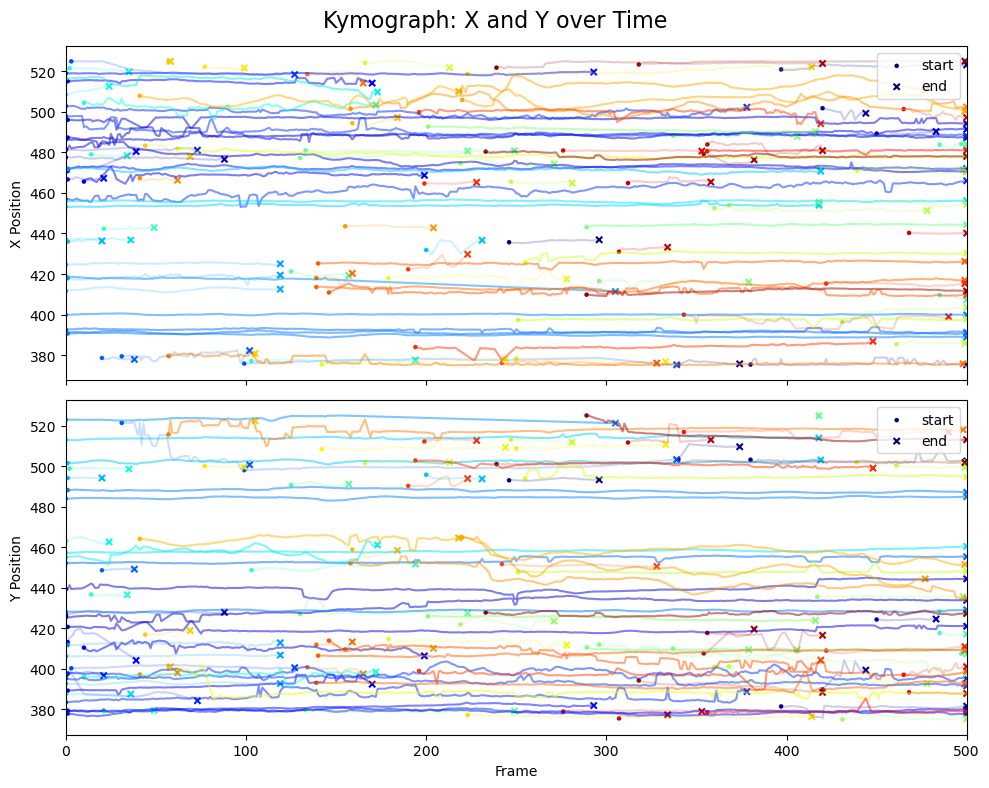

In [64]:
COLOR_LEN_THRES = 100

# Create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

colors = np.arange(len(small_range_df["track_id"].unique()))

startPoints = []
endPoints = []

# Group by trackid and plot for each track
for i, (track_id, track_data) in enumerate(small_range_df.groupby('track_id')):
    # Plot the x position over time in the first subplot
    # Check if the track length is shorter than the specified threshold
    track_length = len(track_data)
    if track_length < COLOR_LEN_THRES:
        alpha = 0.2  # Color for short tracks 
    else:
        alpha = 0.5  # Color for longer tracks

    axs[0].plot(track_data['frame'], track_data['x'], alpha=alpha, color=plt.cm.jet(colors[i] / len(colors)))
    axs[1].plot(track_data['frame'], track_data['y'], alpha=alpha, color=plt.cm.jet(colors[i] / len(colors)))

    startPoints.append((track_data['x'].iloc[0],track_data['y'].iloc[0],track_data['frame'].iloc[0],colors[i] / len(colors)))
    endPoints.append((track_data['x'].iloc[-1],track_data['y'].iloc[-1],track_data['frame'].iloc[-1],colors[i] / len(colors)))

startPoints = np.array(startPoints)
endPoints = np.array(endPoints)
axs[0].scatter(startPoints[:,2], startPoints[:,0],s=20,c=startPoints[:,3],cmap="jet",marker=".", label="start")
axs[0].scatter(endPoints[:,2], endPoints[:,0],s=20,c=startPoints[:,3],cmap="jet",marker="x", label="end")
axs[1].scatter(startPoints[:,2], startPoints[:,1],s=20,c=startPoints[:,3],cmap="jet",marker=".", label="start")
axs[1].scatter(endPoints[:,2], endPoints[:,1],s=20,c=startPoints[:,3],cmap="jet",marker="x", label="end")

# Set labels for both subplots
axs[0].set_ylabel('X Position')
axs[1].set_ylabel('Y Position')
axs[1].set_xlabel('Frame')
axs[0].set_xlim(trange)

axs[0].legend(loc="upper right")
axs[1].legend(loc="upper right")

# Add a title to the figure
fig.suptitle('Kymograph: X and Y over Time', fontsize=16)

plt.tight_layout()